## MNIST Image Classification with a CNN Model

### Build the dataset and dataloader

In [1]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./assets', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./assets', train=False, download=False, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

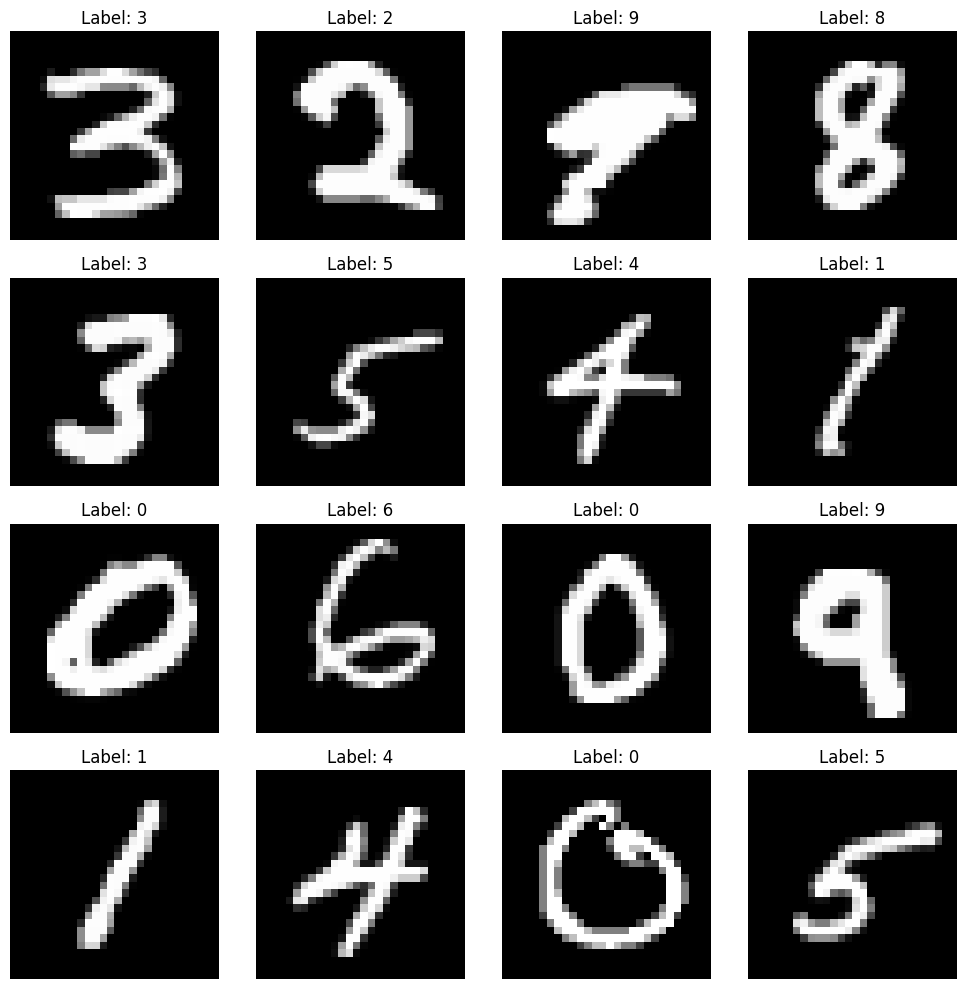

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build the CNN Model

In [3]:
import torch
import torch.nn as nn

# 3-layer CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(800, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        y = self.features(x)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        
        return y


# Create an instance of the CNN model
model = CNN()
x = torch.randn(64, 1, 28, 28)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
torch.Size([64, 10])
Number of parameters: 108,618


### Define the loss function and optimizer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [5]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:13<02:02, 13.65s/it]

Epoch: 1, Loss: 0.1923


 20%|██        | 2/10 [00:25<01:41, 12.67s/it]

Epoch: 2, Loss: 0.0553


 30%|███       | 3/10 [00:37<01:27, 12.50s/it]

Epoch: 3, Loss: 0.0382


 40%|████      | 4/10 [00:50<01:15, 12.60s/it]

Epoch: 4, Loss: 0.0296


 50%|█████     | 5/10 [01:03<01:03, 12.79s/it]

Epoch: 5, Loss: 0.0233


 60%|██████    | 6/10 [01:17<00:52, 13.04s/it]

Epoch: 6, Loss: 0.0181


 70%|███████   | 7/10 [01:31<00:39, 13.27s/it]

Epoch: 7, Loss: 0.0134


 80%|████████  | 8/10 [01:44<00:26, 13.44s/it]

Epoch: 8, Loss: 0.0128


 90%|█████████ | 9/10 [01:58<00:13, 13.58s/it]

Epoch: 9, Loss: 0.0095


100%|██████████| 10/10 [02:12<00:00, 13.29s/it]

Epoch: 10, Loss: 0.0100


### Evaluate the model

In [6]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9915


### Predict on sample images

In [ ]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
